<hr style="margin-bottom: 40px;">

<img src="ship.png"
    style="width:300px; float: right; margin: 0 40px 40px 40px;"></img>
    
    
# Titanic - Logistic Regression Project

For this project I'll be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). 

I'll try to predict a classification- survival or deceased.

## Import Libraries

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression

## Acquire data

I start by acquiring the training and testing datasets into Pandas DataFrames. I also combine these datasets to run certain operations on both datasets together.

In [2]:
train_df = pd.read_csv('Titanic_Dataset_Train.csv')
test_df = pd.read_csv('Titanic_Dataset_Test.csv')
combine = [train_df, test_df]

## Analyze by describing data


**Which features are available in the dataset?**

In [3]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


**Which features are categorical? This will help us select the appropiate plots for visualization.**

- Categorical: Survived, Sex, and Embarked.
- Ordinal: Pclass.

**Which features are numerical?**

- Continous: Age, Fare.
- Discrete: SibSp, Parch.

In [4]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Which features are mixed data types?**

Numerical, alphanumeric data within same feature. These are candidates for correcting goal.

- Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.

**Which features may contain errors or typos?**

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

- Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

In [5]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


**Which features contain blank, null or empty values?**

These will require correcting.

- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
- Cabin > Age are incomplete in case of test dataset.

**What are the data types for various features?**

Helping us during converting goal.

- Seven features are integer or floats. Six in case of test dataset.
- Five features are strings (object).

In [6]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

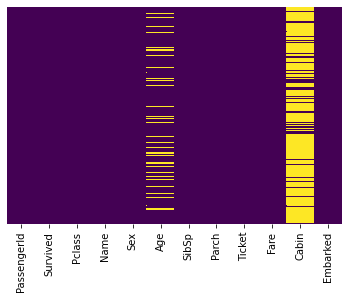

In [7]:
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

**What is the distribution of numerical feature values across the samples?**

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

- Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
- Survived is a categorical feature with 0 or 1 values.
- Around 38% samples survived representative of the actual survival rate at 32%.
- Most passengers (> 75%) did not travel with parents or children.
- Nearly 30% of the passengers had siblings and/or spouse aboard.
- Fares varied significantly with few passengers (<1%) paying as high as $512.
- Few elderly passengers (<1%) within age range 65-80.

In [8]:
train_df.describe()
# Review survived rate using `percentiles=[.61, .62]` knowing our problem description mentions 38% survival rate.
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**What is the distribution of categorical features?**

- Names are unique across the dataset (count=unique=891)
- Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
- Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
- Embarked takes three possible values. S port used by most passengers (top=S)
- Ticket feature has high ratio (22%) of duplicate values (unique=681).

In [9]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


### Assumtions based on data analysis

We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

**Correlating.**

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

**Completing.**

1. We may want to complete Age feature as it is definitely correlated to survival.
2. We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

**Correcting.**

1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
2. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
3. PassengerId may be dropped from training dataset as it does not contribute to survival.
4. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

**Creating.**

1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. We may want to engineer the Name feature to extract Title as a new feature.
3. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. We may also want to create a Fare range feature if it helps our analysis.

**Classifying.**

We may also add to our assumptions based on the problem description noted earlier.

1. Women (Sex=female) were more likely to have survived.
2. Children (Age<?) were more likely to have survived. 
3. The upper-class passengers (Pclass=1) were more likely to have survived.

## Analyze by pivoting features

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

- **Pclass** We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
- **Sex** We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
- **SibSp and Parch** These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating #1).

In [10]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


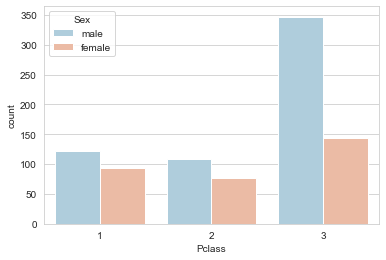

In [11]:
sns.set_style('whitegrid')
sns.countplot(x='Pclass',hue='Sex',data=train_df,palette='RdBu_r')

In [12]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


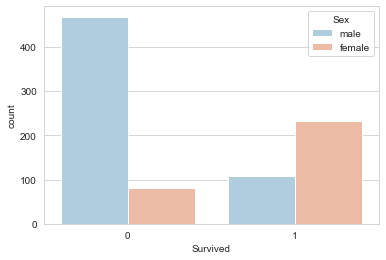

In [13]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train_df,palette='RdBu_r')

In [14]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


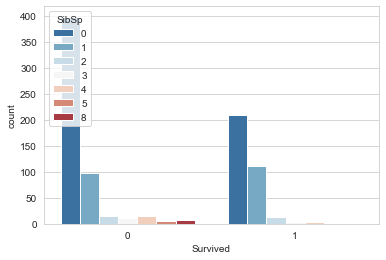

In [15]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='SibSp',data=train_df,palette='RdBu_r')

In [16]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


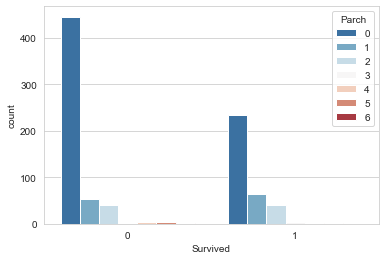

In [17]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Parch',data=train_df,palette='RdBu_r')

## Analyze by visualizing data

Now we can continue confirming some of our assumptions using visualizations for analyzing the data.

### Correlating numerical features

Let us start by understanding correlations between numerical features and our solution goal (Survived).

A histogram chart is useful for analyzing continous numerical variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did infants have better survival rate?)

Note that x-axis in historgram visualizations represents the count of samples or passengers.

**Observations.**

- Infants (Age <=4) had high survival rate.
- Oldest passengers (Age = 80) survived.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

**Decisions.**

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

- We should consider Age (our assumption classifying #2) in our model training.
- Complete the Age feature for null values (completing #1).
- We should band age groups (creating #3).

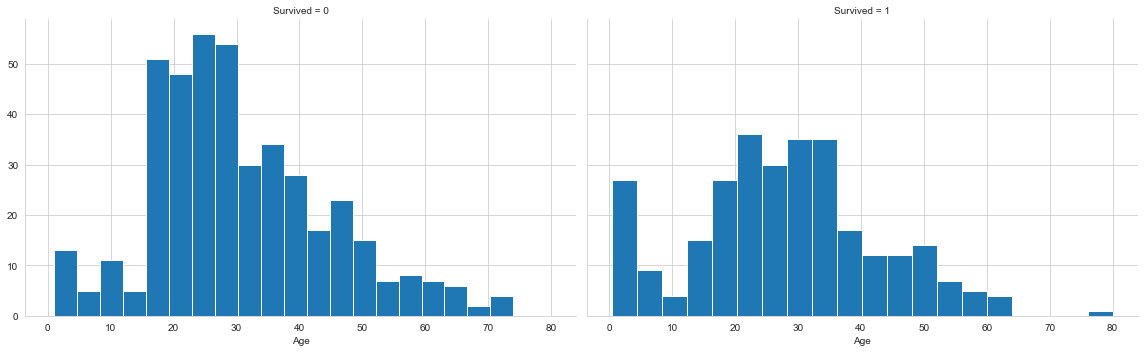

In [18]:
g = sns.FacetGrid(train_df, col='Survived', height=5, aspect=1.6,palette='RdBu_r')
g.map(plt.hist, 'Age', bins=20)

### Correlating numerical and ordinal features

We can combine multiple features for identifying correlations using a single plot. This can be done with numerical and categorical features which have numeric values.

**Observations.**

- Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
- Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
- Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
- Pclass varies in terms of Age distribution of passengers.

**Decisions.**

- Consider Pclass for model training.

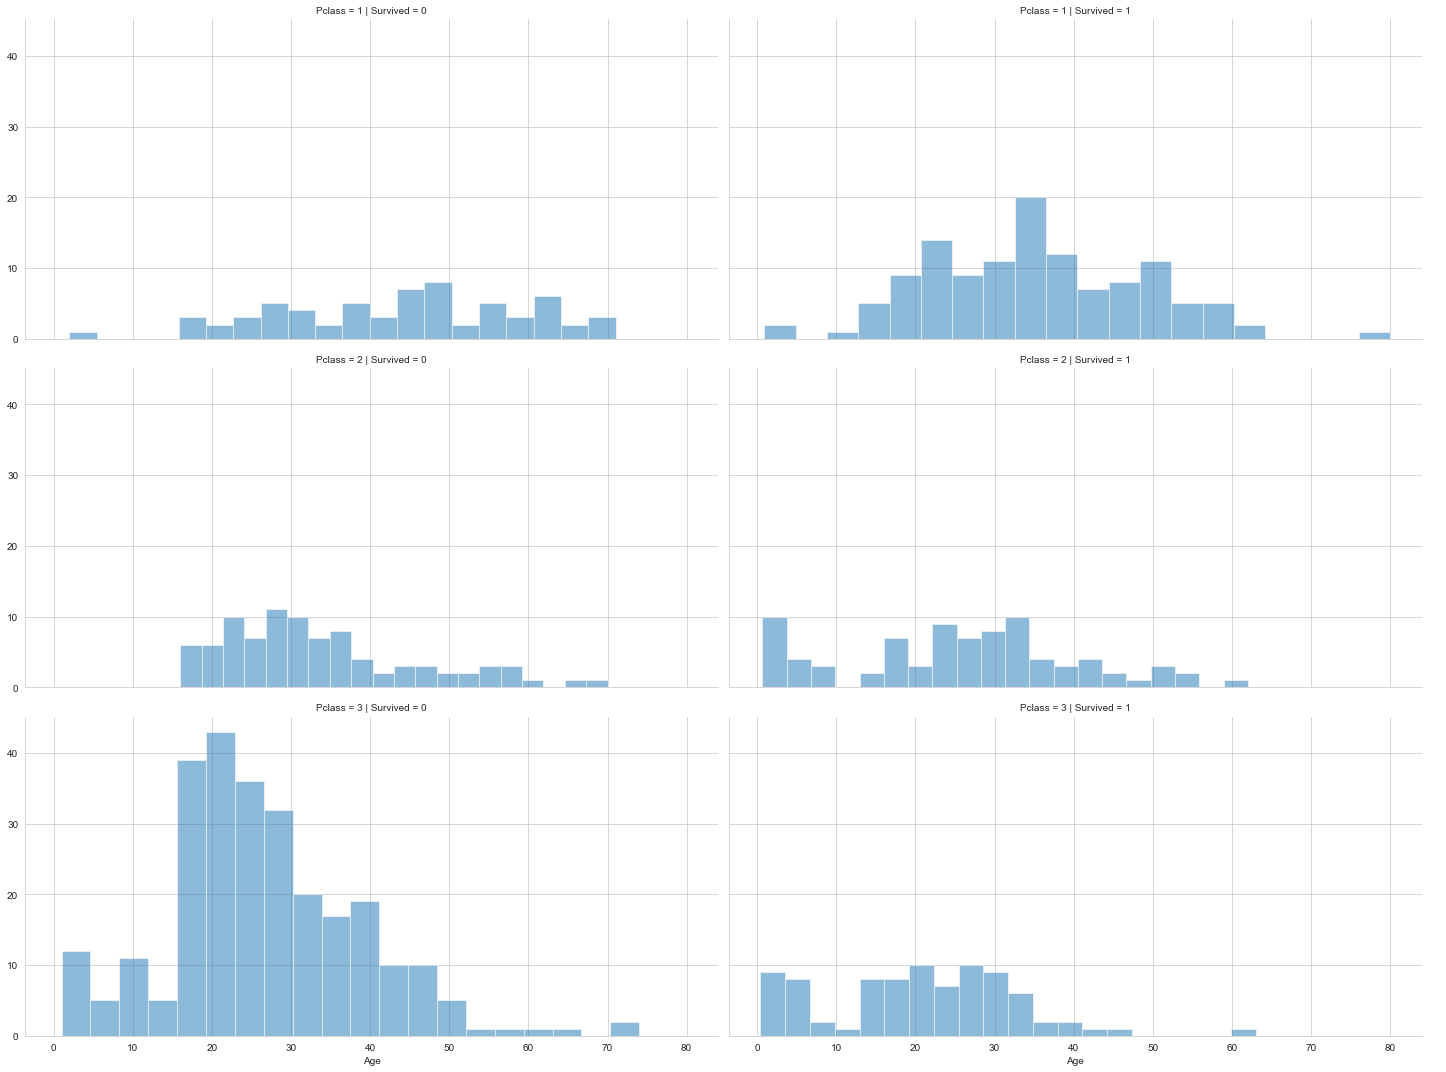

In [19]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=5, aspect=2,palette='RdBu_r')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Correlating categorical features

Now we can correlate categorical features with our solution goal.

**Observations.**

- Female passengers had much better survival rate than males. Confirms classifying (#1).
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing (#2).
- Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating (#1).

**Decisions.**

- Add Sex feature to model training.
- Complete and add Embarked feature to model training.

C:\Users\FEDE\Anaconda3\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\FEDE\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


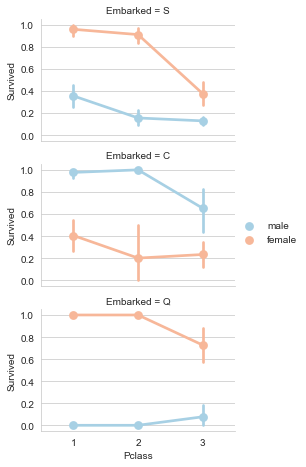

In [20]:
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='RdBu_r')
grid.add_legend()

### Correlating categorical and numerical features

We may also want to correlate categorical features (with non-numeric values) and numeric features. We can consider correlating Embarked (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with Survived (Categorical numeric).

**Observations.**

- Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
- Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

**Decisions.**

- Consider banding Fare feature.

C:\Users\FEDE\Anaconda3\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


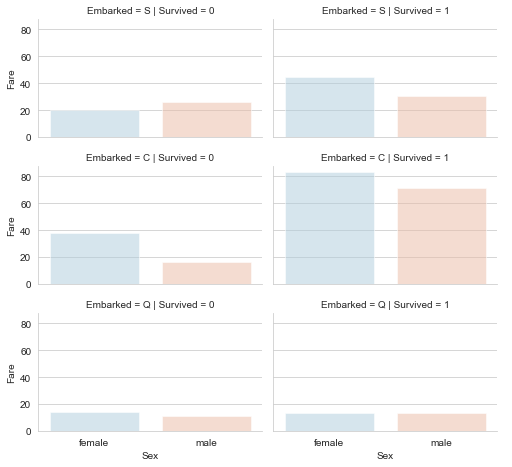

In [21]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None, palette='RdBu_r')
grid.add_legend()

## Wrangle data

We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating, and completing goals.

### Correcting by dropping features

This is a good starting goal to execute. By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.

Based on our assumptions and decisions we want to drop the Cabin (correcting #2) and Ticket (correcting #1) features.

Note that where applicable we perform operations on both training and testing datasets together to stay consistent.

In [22]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 10) (418, 9) (891, 10) (418, 9)


### Creating new feature extracting from existing

We want to analyze if Name feature can be engineered to extract titles and test correlation between titles and survival, before dropping Name and PassengerId features.

In the following code we extract Title feature using regular expressions. The RegEx pattern `(\w+\.)` matches the first word which ends with a dot character within Name feature. The `expand=False` flag returns a DataFrame.

**Observations.**

When we plot Title, Age, and Survived, we note the following observations.

- Most titles band Age groups accurately. For example: Master title has Age mean of 5 years.
- Survival among Title Age bands varies slightly.
- Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer).

**Decision.**

- We decide to retain the new Title feature for model training.

In [23]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We can replace many titles with a more common name or classify them as `Rare`.

In [24]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


We can convert the categorical titles to ordinal.

In [25]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Now we can safely drop the Name feature from training and testing datasets. We also do not need the PassengerId feature in the training dataset.

In [26]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### Converting a categorical feature

Now we can convert features which contain strings to numerical values. This is required by most model algorithms. Doing so will also help us in achieving the feature completing goal.

Let us start by converting Sex feature to a new feature called Gender where female=1 and male=0.

In [27]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


### Completing a numerical continuous feature

Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

We can consider three methods to complete a numerical continuous feature.

1. A simple way is to generate random numbers between mean and [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation).

2. More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using [median](https://en.wikipedia.org/wiki/Median) values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

3. Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.

Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary. We will prefer method 2.

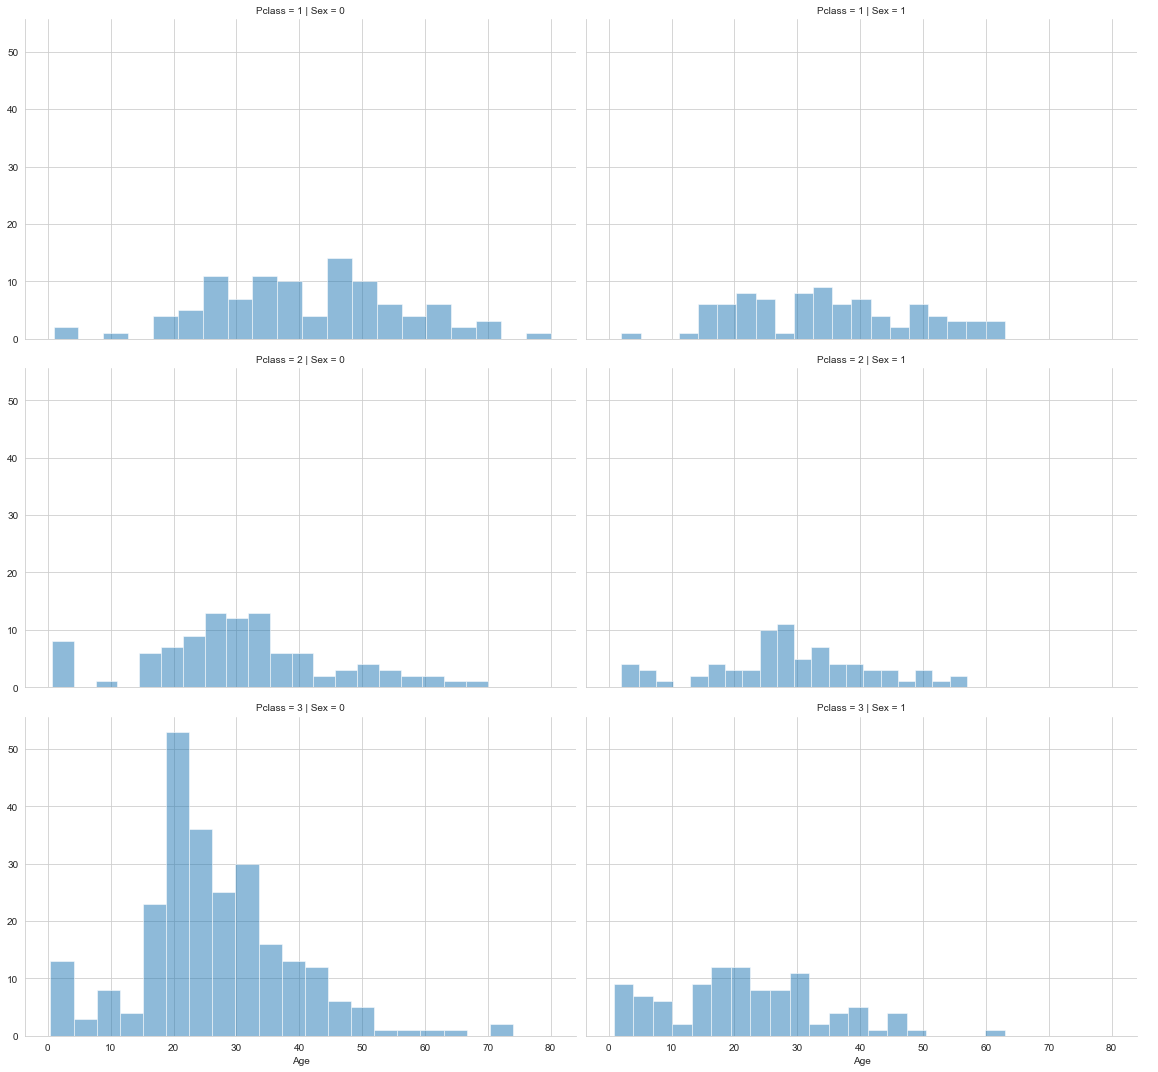

In [28]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=5, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations.

In [29]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.

In [30]:
import math
for dataset in combine: # train/test
    for i in range(0, 2): # 0/1
        for j in range(0, 3): # j+1 -> 1/2/3
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            # guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            guess_ages[i,j] = math.floor(age_guess)
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Let us create Age bands and determine correlations with Survived.

In [31]:
pd.cut(train_df['Age'], 5)

0      (16.0, 32.0]
1      (32.0, 48.0]
2      (16.0, 32.0]
3      (32.0, 48.0]
4      (32.0, 48.0]
           ...     
886    (16.0, 32.0]
887    (16.0, 32.0]
888    (16.0, 32.0]
889    (16.0, 32.0]
890    (16.0, 32.0]
Name: Age, Length: 891, dtype: category
Categories (5, interval[float64]): [(-0.08, 16.0] < (16.0, 32.0] < (32.0, 48.0] < (48.0, 64.0] < (64.0, 80.0]]

In [32]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Let us replace Age with ordinals based on these bands.

In [33]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


We can now remove the AgeBand feature.

In [34]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### Create new feature combining existing features

We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.

In [35]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


We can create another feature called IsAlone.

In [36]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Let us drop Parch, SibSp, and FamilySize features in favor of IsAlone.

In [37]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


We can also create an artificial feature combining Pclass and Age.

In [38]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing a categorical feature

Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [39]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [40]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Converting categorical feature to numeric

We can now convert the EmbarkedFill feature by creating a new numeric Port feature.

In [41]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


### Quick completing and converting a numeric feature

We can now complete the Fare feature for single missing value in test dataset using mode to get the value that occurs most frequently for this feature. We do this in a single line of code.

Note that we are not creating an intermediate new feature or doing any further analysis for correlation to guess missing feature as we are replacing only a single value. The completion goal achieves desired requirement for model algorithm to operate on non-null values.

We may also want round off the fare to two decimals as it represents currency.

In [42]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


We can now create FareBand.

In [43]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Convert the Fare feature to ordinal values based on the FareBand.

In [44]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


And the test dataset.

In [45]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


## Regression Model, predict and solve

In [62]:
X = train_df.drop('Survived',axis=1)
y = train_df['Survived']

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [66]:
logmodel = LogisticRegression()

In [67]:
logmodel.fit(X_train,y_train)

LogisticRegression()

In [68]:
predictions = logmodel.predict(X_test)

In [69]:
from sklearn.metrics import classification_report

In [70]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       154
           1       0.82      0.67      0.73       114

    accuracy                           0.79       268
   macro avg       0.80      0.78      0.78       268
weighted avg       0.80      0.79      0.79       268



In [71]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,predictions))

[[137  17]
 [ 38  76]]


In [72]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution.

Note the confidence score generated by the model based on our training dataset.

In [73]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_predictions = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.36

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

- Sex is highest positivie coefficient, implying as the Sex value increases (male: 0 to female: 1), the probability of Survived=1 increases the most.
- Inversely as Pclass increases, probability of Survived=1 decreases the most.
- This way Age*Class is a good artificial feature to model as it has second highest negative correlation with Survived.
- So is Title as second highest positive correlation.

In [74]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201619
5,Title,0.397888
2,Age,0.287011
4,Embarked,0.261473
6,IsAlone,0.126553
3,Fare,-0.086655
7,Age*Class,-0.311069
0,Pclass,-0.750700
